In [1]:
import warnings
warnings.filterwarnings("ignore")

# 다중공선성

다중공선성(multicollinearity)란 독립 변수의 일부가 다른 독립 변수의 조합으로 표현될 수 있는 경우이다. 독립 변수들이 서로 독립이 아니라 상호상관관계가 강한 경우에 발생한다. 이는 독립 변수의 공분산 행렬이 full rank 이어야 한다는 조건을 침해한다.

다음 데이터는 미국의 거시경제지표를 나타낸 것이다. 

* TOTEMP - Total Employment
* GNPDEFL - GNP deflator
* GNP - GNP
* UNEMP - Number of unemployed
* ARMED - Size of armed forces
* POP - Population
* YEAR - Year (1947 - 1962)

스캐터 플롯에서 보듯이 독립변수간의 상관관계가 강하다.

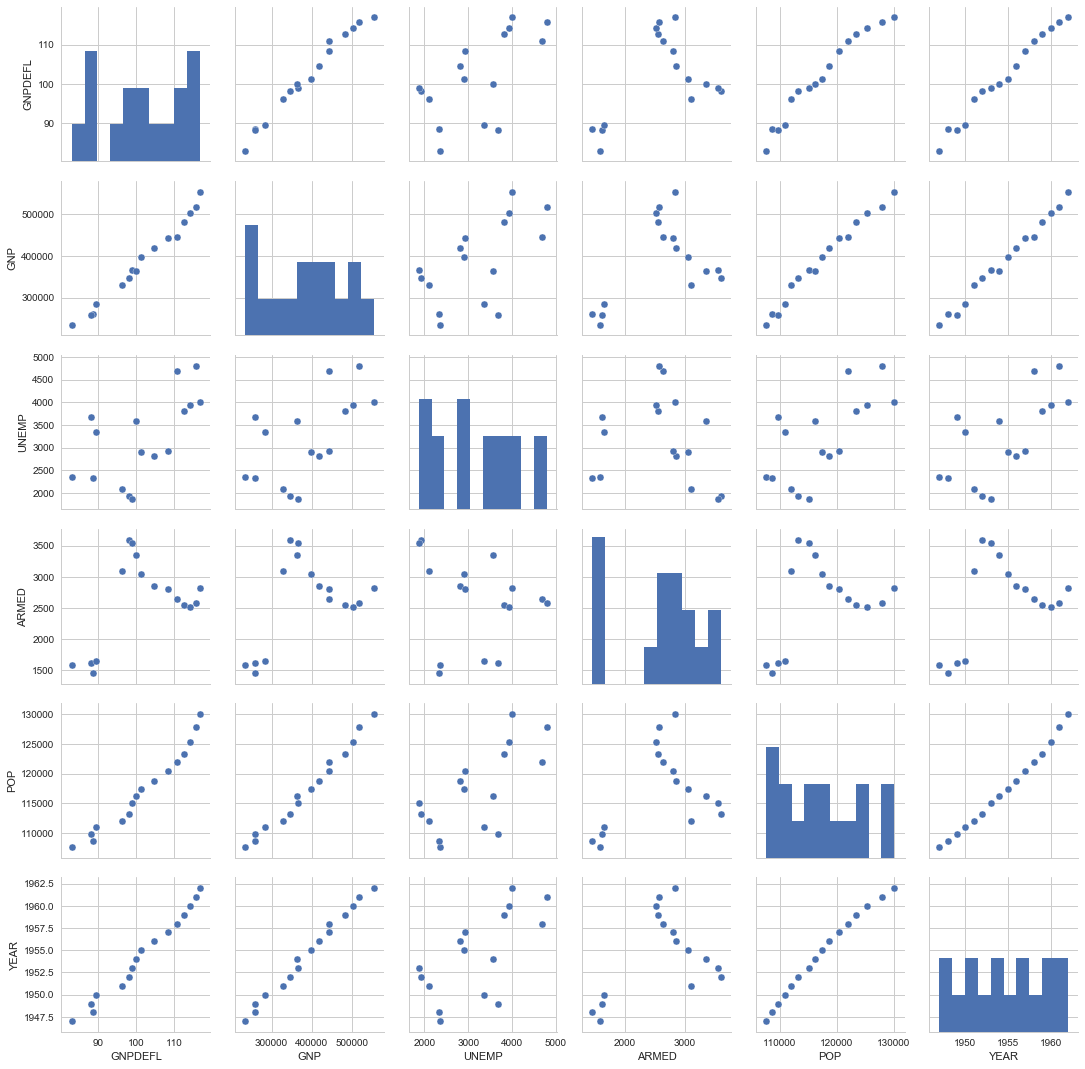

In [4]:
%matplotlib inline
from statsmodels.datasets.longley import load_pandas
dfy = load_pandas().endog
dfX = load_pandas().exog
df = pd.concat([dfy, dfX], axis=1)
sns.pairplot(dfX)
plt.show()

상관관계는 상관계수 행렬로도 살펴볼 수 있다.

In [5]:
dfX.corr()

,GNPDEFL,GNP,UNEMP,ARMED,POP,YEAR
GNPDEFL,1.000000,0.991589,0.620633,0.464744,0.979163,0.991149
GNP,0.991589,1.000000,0.604261,0.446437,0.991090,0.995273
UNEMP,0.620633,0.604261,1.000000,-0.177421,0.686552,0.668257
ARMED,0.464744,0.446437,-0.177421,1.000000,0.364416,0.417245
POP,0.979163,0.991090,0.686552,0.364416,1.000000,0.993953
YEAR,0.991149,0.995273,0.668257,0.417245,0.993953,1.000000


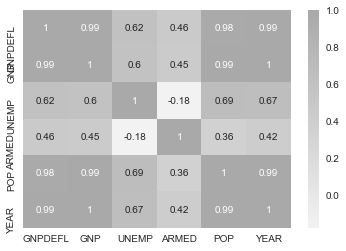

In [6]:
cmap = sns.light_palette("darkgray", as_cmap=True)
sns.heatmap(dfX.corr(), annot=True, cmap=cmap)
plt.show()

In [7]:
model = sm.OLS.from_formula("TOTEMP ~ "
                            "GNPDEFL + POP + GNP + "
                            "YEAR + ARMED + UNEMP", data=df)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 TOTEMP   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     330.3
Date:                Tue, 03 Jul 2018   Prob (F-statistic):           4.98e-10
Time:                        16:50:06   Log-Likelihood:                -109.62
No. Observations:                  16   AIC:                             233.2
Df Residuals:                       9   BIC:                             238.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -3.482e+06    8.9e+05     -3.911      0.0

다중 공선성이 있으면 독립변수의 공분산 행렬의 조건수(conditional number)가 증가한다.  조건수는 독립변수가 스케일링이 되어 있지 않아도 증가하므로 일단 스케일링을 통해 조건수를 감소시킨다.

In [8]:
model = sm.OLS.from_formula("TOTEMP ~ "
                            "scale(GNPDEFL) + scale(POP) + scale(GNP) + "
                            "scale(YEAR) + scale(ARMED) + scale(UNEMP)", data=df)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 TOTEMP   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     330.3
Date:                Tue, 03 Jul 2018   Prob (F-statistic):           4.98e-10
Time:                        16:50:09   Log-Likelihood:                -109.62
No. Observations:                  16   AIC:                             233.2
Df Residuals:                       9   BIC:                             238.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       6.532e+04     76.214    857.

독립 변수가 서로 의존하게 되면 이른바 과최적화(over-fitting) 문제가 발생하여 회귀 결과의 안정성을 해치게 된다. 이를 방지하는 방법들은 다음과 같다.

* 변수 선택법으로 의존적인 변수 삭제
* PCA(principal component analysis) 방법으로 의존적인 성분 삭제
* 정규화(regularized) 방법 사용

## VIF

다중 공선성을 없애는 가장 기본적인 방법은 다른 독립변수에 의존하는 변수를 없애는 것이다. 가장 의존적인 독립변수를 선택하는 방법으로는 VIF(Variance Inflation Factor)를 사용할 수 있다. VIF는 $i$번째 독립변수를 $i$를 제외한 나머지 독립변수로 선형회귀한 성능을 나타낸 것이다. $i$번째 변수의 VIF는 다음과 같이 계산한다.

$$ \text{VIF}_i = \frac{\sigma^2}{(n-1)\text{Var}[X_i]}\cdot \frac{1}{1-R_i^2} $$

여기에서 $R^2_i$는 다른 변수로 $i$번째 변수를 선형회귀한 성능(결정 계수)이다. 다른 변수에 의존적일 수록 VIF가 커지므로 VIF가 큰 값인 변수부터 제거한다.

StatsModels에서는 `variance_inflation_factor` 명령으로 VIF를 계산한다.

In [15]:
dfX

,GNPDEFL,GNP,UNEMP,ARMED,POP,YEAR
0,83.0,234289.0,2356.0,1590.0,107608.0,1947.0
1,88.5,259426.0,2325.0,1456.0,108632.0,1948.0
2,88.2,258054.0,3682.0,1616.0,109773.0,1949.0
3,89.5,284599.0,3351.0,1650.0,110929.0,1950.0
4,96.2,328975.0,2099.0,3099.0,112075.0,1951.0
5,98.1,346999.0,1932.0,3594.0,113270.0,1952.0
6,99.0,365385.0,1870.0,3547.0,115094.0,1953.0
7,100.0,363112.0,3578.0,3350.0,116219.0,1954.0
8,101.2,397469.0,2904.0,3048.0,117388.0,1955.0
9,104.6,419180.0,2822.0,2857.0,118734.0,1956.0


In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(dfX.values, i) for i in range(dfX.shape[1])]
vif["features"] = dfX.columns
vif

,VIF Factor,features
0,12425.514335,GNPDEFL
1,10290.435437,GNP
2,136.224354,UNEMP
3,39.983386,ARMED
4,101193.161993,POP
5,84709.950443,YEAR


- 상관계수와 VIF를 사용하여 독립 변수를 선택하면 GNP, ARMED, UNEMP 세가지 변수만으로도 비슷한 수준의 성능이 나온다는 것을 알 수 있다.
- VIF가 큰 변수부터 하나씩 제거할 때마다 다시 시행해 값을 확인해 본다.
- 변수를 제거했는데 $R^2$ 값이 많이 줄어들지 않거나 VIF가 작지만 p-value가 큰 변수는 제거한다.
- 최종적으로 조건수가 10 이내로 줄어들 때까지 VIF를 시행한다. 

In [16]:
model2 = sm.OLS.from_formula("TOTEMP ~ scale(GNP) + scale(ARMED) + scale(UNEMP)", data=df)
result2 = model2.fit()
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:                 TOTEMP   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     264.4
Date:                Tue, 03 Jul 2018   Prob (F-statistic):           3.19e-11
Time:                        16:57:46   Log-Likelihood:                -119.16
No. Observations:                  16   AIC:                             246.3
Df Residuals:                      12   BIC:                             249.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     6.532e+04    119.824    545.106   

- 조건수가 낮고 $R^2$가 큰 모델이 cross validation에서 더 좋은 결과가 나올 가능성이 높다.

## 보스턴 집값 예측 문제에 응용

In [17]:
from sklearn.datasets import load_boston
boston = load_boston()

dfX0 = pd.DataFrame(boston.data, columns=boston.feature_names)

from patsy import dmatrix

formula = "scale(CRIM) + scale(I(CRIM ** 2)) + " + \
    "scale(ZN) + scale(I(ZN ** 2)) + scale(INDUS) + " + \
    "scale(NOX) + scale(RM) + scale(AGE) + " + \
    "scale(np.log(DIS)) + scale(RAD) + scale(TAX) + " + \
    "scale(np.log(PTRATIO)) + scale(B) + scale(np.log(LSTAT)) + CHAS"
dfX = dmatrix(formula, dfX0, return_type="dataframe")
dfy = pd.DataFrame(boston.target, columns=["MEDV"])

In [18]:
idx_outlier = \
     np.array([  7,  54, 148, 152, 160, 214, 253, 267, 364, 365, 367, 368, 369,
               371, 372, 374, 380, 385, 397, 398, 399, 400, 401, 405, 409, 410,
               412, 413, 414, 415, 416, 418, 419, 426, 445, 489, 490, 492, 505,
               161, 162, 163, 166, 186, 195, 204, 225, 257, 267, 283, 368, 369,
               370, 371, 372])
    
idx = list(set(range(len(dfX))).difference(idx_outlier))
dfX = dfX.iloc[idx, :].reset_index(drop=True)
dfy = dfy.iloc[idx, :].reset_index(drop=True)

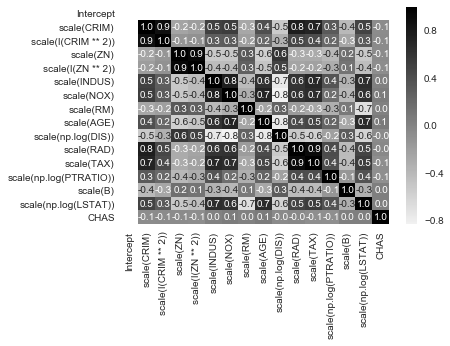

In [19]:
cmap = sns.light_palette("black", as_cmap=True)
sns.heatmap(dfX.corr(), annot=True, fmt='3.1f', cmap=cmap)
plt.show()

In [21]:
dfX.tail()

,Intercept,scale(CRIM),scale(I(CRIM ** 2)),scale(ZN),scale(I(ZN ** 2)),scale(INDUS),scale(NOX),scale(RM),scale(AGE),scale(np.log(DIS)),scale(RAD),scale(TAX),scale(np.log(PTRATIO)),scale(B),scale(np.log(LSTAT)),CHAS
451,1.0,-0.392323,-0.168934,-0.487722,-0.368889,-0.211099,0.261784,-0.367041,0.395615,-0.505483,-0.408041,-0.102376,0.376884,0.441052,0.485410,0.0
452,1.0,-0.411157,-0.169025,-0.487722,-0.368889,0.115738,0.158124,0.439316,0.018673,-0.520096,-0.982843,-0.803212,1.095518,0.387217,-0.169811,0.0
453,1.0,-0.413178,-0.169028,-0.487722,-0.368889,0.115738,0.158124,-0.234548,0.288933,-0.668950,-0.982843,-0.803212,1.095518,0.441052,-0.274682,0.0
454,1.0,-0.411374,-0.169025,-0.487722,-0.368889,0.115738,0.158124,0.984960,0.797449,-0.768920,-0.982843,-0.803212,1.095518,0.441052,-1.067939,0.0
455,1.0,-0.405689,-0.169009,-0.487722,-0.368889,0.115738,0.158124,0.725672,0.736996,-0.588482,-0.982843,-0.803212,1.095518,0.403225,-0.836660,0.0


In [12]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(dfX.values, i) for i in range(dfX.shape[1])]
vif["features"] = dfX.columns
vif = vif.sort_values("VIF Factor").reset_index(drop=True)
vif

,VIF Factor,features
0,1.061624,CHAS
1,1.338325,scale(B)
2,1.489092,Intercept
3,1.780320,scale(np.log(PTRATIO))
4,2.596496,scale(RM)
5,3.748931,scale(AGE)
6,3.807459,scale(INDUS)
7,4.682812,scale(np.log(LSTAT))
8,5.071802,scale(NOX)
9,5.215025,scale(np.log(DIS))


In [13]:
model_boston1 = sm.OLS(np.log(dfy), dfX)
result_boston1 = model_boston1.fit()
print(result_boston1.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     199.9
Date:                Sat, 30 Jun 2018   Prob (F-statistic):          1.56e-185
Time:                        17:17:09   Log-Likelihood:                 317.45
No. Observations:                 456   AIC:                            -602.9
Df Residuals:                     440   BIC:                            -536.9
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  3

In [14]:
cols = ["Intercept", "CHAS", "scale(B)", "scale(CRIM)", 
        "scale(np.log(PTRATIO))", "scale(RM)", "scale(np.log(LSTAT))"]

model_boston2 = sm.OLS(np.log(dfy), dfX[cols])
result_boston2 = model_boston2.fit()
print(result_boston2.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     380.7
Date:                Sat, 30 Jun 2018   Prob (F-statistic):          1.42e-172
Time:                        17:17:09   Log-Likelihood:                 260.52
No. Observations:                 456   AIC:                            -507.0
Df Residuals:                     449   BIC:                            -478.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  3